In [ ]:
import tensorflow as tf
import keras 
import numpy as np
import matplotlib.pyplot as plt 
from numpy import expand_dims
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam 
from keras.layers import Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import LSTM, GRU
from keras.layers import Dropout 
from keras import initializers 
from keras.utils import np_utils
from keras.layers import Conv2DTranspose
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from numpy import vstack
from matplotlib import pyplot

#Data Loading: Fashion_Mnist Using Keras 

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("x_train shape:", x_train.shape, "y_train shape", y_train.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape (60000,)


Info about the data 

In [ ]:
numbers_of_classes = 10 
batch_size = 128 
numbers_of_lstm_outputs = 30 




Apply One Hot Encoding and scaling 

In [ ]:
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255. 
y_train = np_utils.to_categorical(y_train, numbers_of_classes)
y_test = np_utils.to_categorical(y_test, numbers_of_classes)

# Build the Discriminator Model 

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

#Build the Generator Model 

In [ ]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model


#Build the gan 

In [ ]:
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

#Load real image samples

In [ ]:
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

#Generate real samples

In [ ]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

#Generate latenent points

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

#Fake samples generate

In [ ]:
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

#Save plot

In [ ]:
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

#Summarize performance

In [ ]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)


#Training

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>1, 1/234, d=0.701, g=0.678


KeyboardInterrupt: ignored

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
>79, 155/234, d=0.694, g=0.704
>79, 156/234, d=0.688, g=0.717
>79, 157/234, d=0.694, g=0.715
>79, 158/234, d=0.693, g=0.712
>79, 159/234, d=0.688, g=0.708
>79, 160/234, d=0.694, g=0.704
>79, 161/234, d=0.695, g=0.699
>79, 162/234, d=0.696, g=0.696
>79, 163/234, d=0.697, g=0.701
>79, 164/234, d=0.693, g=0.700
>79, 165/234, d=0.692, g=0.684
>79, 166/234, d=0.693, g=0.678
>79, 167/234, d=0.693, g=0.681
>79, 168/234, d=0.688, g=0.680
>79, 169/234, d=0.690, g=0.691
>79, 170/234, d=0.689, g=0.696
>79, 171/234, d=0.694, g=0.708
>79, 172/234, d=0.699, g=0.699
>79, 173/234, d=0.690, g=0.705
>79, 174/234, d=0.692, g=0.708
>79, 175/234, d=0.697, g=0.706
>79, 176/234, d=0.693, g=0.706
>79, 177/234, d=0.695, g=0.701
>79, 178/234, d=0.691, g=0.694
>79, 179/234, d=0.692, g=0.686
>79, 180/234, d=0.692, g=0.691
>79, 181/234, d=0.691, g=0.683
>79, 182/234, d=0.693, g=0.682
>79, 183/234, d=0.695, g=0.681
>79, 184/234, d=0.696, g=0.680
>79, 185/234, d=0.6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


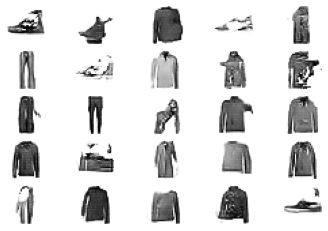

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model

# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = g_model.predict(latent_points)
# plot the result
save_plot(X, 5)

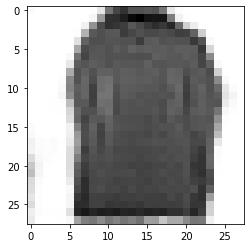

In [ ]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('generator_model_100.h5')
# all 0s
vector = asarray([[0 for _ in range(100)]])
# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()